In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
team_records_initial = pd.read_csv('records.csv')[['year','team','team_wins','team_losses','team_ties','playoffs']]
#team_records = team_records[['year','team','team_wins','team_losses','team_ties']]
df_initial = pd.read_csv('bref.csv')

In [3]:
master_org_dict = {'MON':'WSN',
                   'CAL':'LAA',
                   'WSA':'TEX',
                   'SEP':'MIL',
                   'KCA':'OAK',
                   'MLN':'ATL',
                   'FLA':'MIA',
                   'TBD':'TBR',
                   'WSH':'MIN',
                   'NYG':'SFG',
                   'BRO':'LAD',
                   'PHA':'OAK',
                   'SLB':'BAL',
                   'BSN':'ATL',
                   'ANA':'LAA'
                  }

recs = team_records_initial.copy()
recs['master_team'] = recs['team'].apply(lambda x: master_org_dict[x] if x in master_org_dict else x)
recs2 = recs.copy()
for col in ['team_wins','team_losses','team_ties']:
    recs2 = recs2.rename(columns={col:'%s_prior_year' % col})
recs2['year'] = recs2['year'] + 1
    
recs = pd.merge(recs,recs2,on=['year','team','playoffs','master_team'],how='left')

In [4]:
#couldn't figure out how to denserank within cumcount so went about in a roundabout way
def get_metric_based_rank(data_frame,metrics,asc_or_desc=False):
    for metric in metrics:
        rank_metric = '%s_rank_initial' % metric
        data_frame[rank_metric] = data_frame.sort_values([metric], ascending=[asc_or_desc]).groupby(['year','league']).cumcount() + 1
        test_df = data_frame.copy()
        group = ['league','year',metric]
        test_df = test_df[group+[rank_metric]].groupby(group).min().reset_index()
        test_df = test_df.rename(columns={rank_metric:rank_metric.replace('_initial','')})
        data_frame = pd.merge(data_frame,test_df,on=group,how='left')
    return data_frame

In [5]:
def adjust_data_frame(data_frame):
    for val in ['','_prior_year']:
        win_col = 'team_wins%s' % val
        loss_col = 'team_losses%s' % val
        tie_col = 'team_ties%s' % val
        
        data_frame['team_games_played%s' % val] = data_frame[win_col] + data_frame[loss_col] + data_frame[tie_col]
        data_frame['team_win_pct%s' % val] = data_frame[win_col] / (data_frame[loss_col] + data_frame[win_col])
    data_frame['decade'] = data_frame['year'].apply(lambda x: str(x)[:3] + '0s')
    for col in ['wins','saves']:
        data_frame[col] = data_frame[col].fillna(0)
    data_frame['wins_saves'] = data_frame['wins'] + data_frame['saves']
    #data_frame = data_frame.loc[data_frame.voting_place<=20,:]
    data_frame = data_frame.loc[data_frame.wins_saves==0,:]
    data_frame['wins_improvement'] = data_frame['team_wins'] + data_frame['team_wins_prior_year']
    data_frame['win_pct_improvement'] = data_frame['team_win_pct'] + data_frame['team_win_pct_prior_year']
    data_frame['runs_produced'] = data_frame['runs'] + data_frame['rbi'] - data_frame['home_runs']
    data_frame['90_win_pace'] = data_frame['team_win_pct'] >.555
    
    data_frame['name'] = data_frame['name'].apply(lambda x: x.split(',')[1] + ' ' + x.split(',')[0])
    return data_frame

In [173]:
def format_graph(xlab,ylab,title,legend_loc=None):
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    if legend_loc:
        plt.legend(loc=legend_loc)

In [37]:
df = df_initial.copy()
df = pd.merge(df,recs,on=['team','year'],how='left')
df = adjust_data_frame(df)
#df = df.sort_values(['year','league','points'],ascending=False).reset_index()
# max_year_df = df[['year','league','voting_place']].groupby(['year','league']).min().reset_index()
# max_year_df = max_year_df.rename(columns={'voting_place':'max_finish'})
# df = pd.merge(df,max_year_df,on=['year','league'],how='left')
df = get_metric_based_rank(df,['voting_place'],True)
df['voting_place'] = df['voting_place_rank']
df['winner'] = df['voting_place'] == 1

<ipython-input-5-3f8155c5801e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['wins_improvement'] = data_frame['team_wins'] + data_frame['team_wins_prior_year']
<ipython-input-5-3f8155c5801e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['win_pct_improvement'] = data_frame['team_win_pct'] + data_frame['team_win_pct_prior_year']
<ipython-input-5-3f8155c5801e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [38]:
group_cols = ['year','league']
stats = ['war','rbi','runs','home_runs','team_wins','average','obp','slg','ops','sb','team_win_pct','win_pct_improvement','wins_improvement','runs_produced']
max_df = df[group_cols + stats].groupby(group_cols).max().reset_index()

for val in stats:
    max_df = max_df.rename(columns={val:'max_%s'%val})
    
df = pd.merge(df,max_df,on=['year','league'],how='left')
for col in stats:
    diff_col = '%s_difference' % col
    max_col = 'max_%s' % col
    
    df[diff_col] =  df[max_col] - df[col]
    df['%s_leader' % col] = df[diff_col] == 0
    
    
df = get_metric_based_rank(df,stats)
df['triple_crown_agg_rank'] = df['rbi_rank'] + df['home_runs_rank'] + df['average_rank']
df['expected_vote_place_difference'] = df['war_rank'] - df['voting_place']
df = df.sort_values('decade',ascending=True)

In [39]:
league_leaders_df = pd.DataFrame()

for stat in stats:
    temp = df.loc[df['%s_difference' % stat]==0][['year','team_win_pct','win_pct_improvement','decade','league','voting_place','playoffs','winner','name']]
    temp['metric'] = stat
    league_leaders_df = pd.concat([league_leaders_df,temp])

How League Leaders Of Various Categories Do In Voting Over Time

Text(0.5, 8.959999999999994, 'entry a')

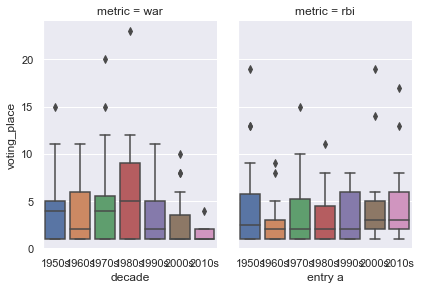

In [166]:
#['average','home_runs','rbi','runs_produced','obp','ops','war','team_wins','win_pct_improvement']

sns.catplot(x="decade", y="voting_place",
                 col="metric",
                data=league_leaders_df[league_leaders_df['metric'].isin(['rbi','war'])].sort_values('decade',ascending=True), kind="box",col_wrap=4,
                height=4, aspect=.7)

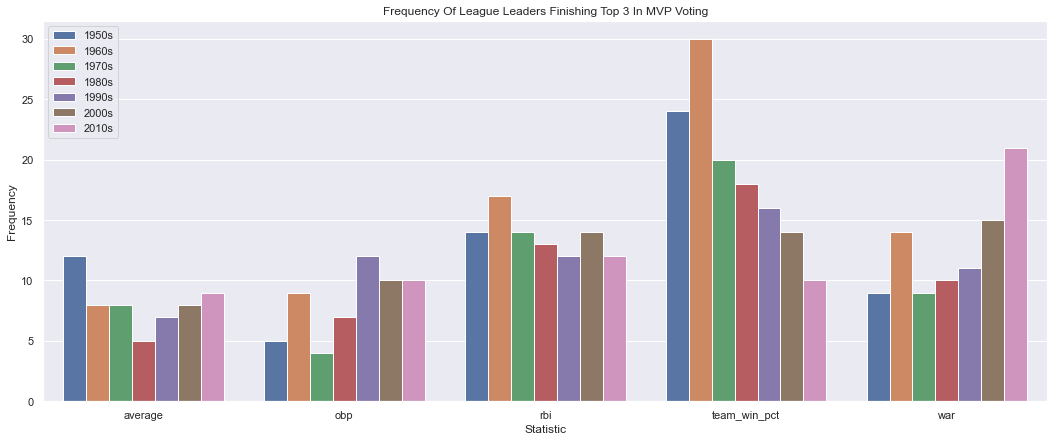

In [176]:
plt.figure(figsize=(18,7))
grouped_df = league_leaders_df.loc[league_leaders_df.voting_place<=3].groupby(['decade','metric']).count().reset_index()
sns.barplot(x='metric', y='name', data=grouped_df.loc[grouped_df.metric.isin(['team_win_pct','war','rbi','obp','average'])], hue="decade")

#     plt.legend(loc='upper left')
#     plt.xlabel('Stat')
#     plt.ylabel('Frequency')
#     plt.title('Frequency Of League Leaders Finishing Top 3 In MVP Voting')

format_graph('Statistic','Frequency','Frequency Of League Leaders Finishing Top 3 In MVP Voting','upper left')

How and players triple crown rank and WAR correlated with MVP voting results over time, and how being a good team impacted things

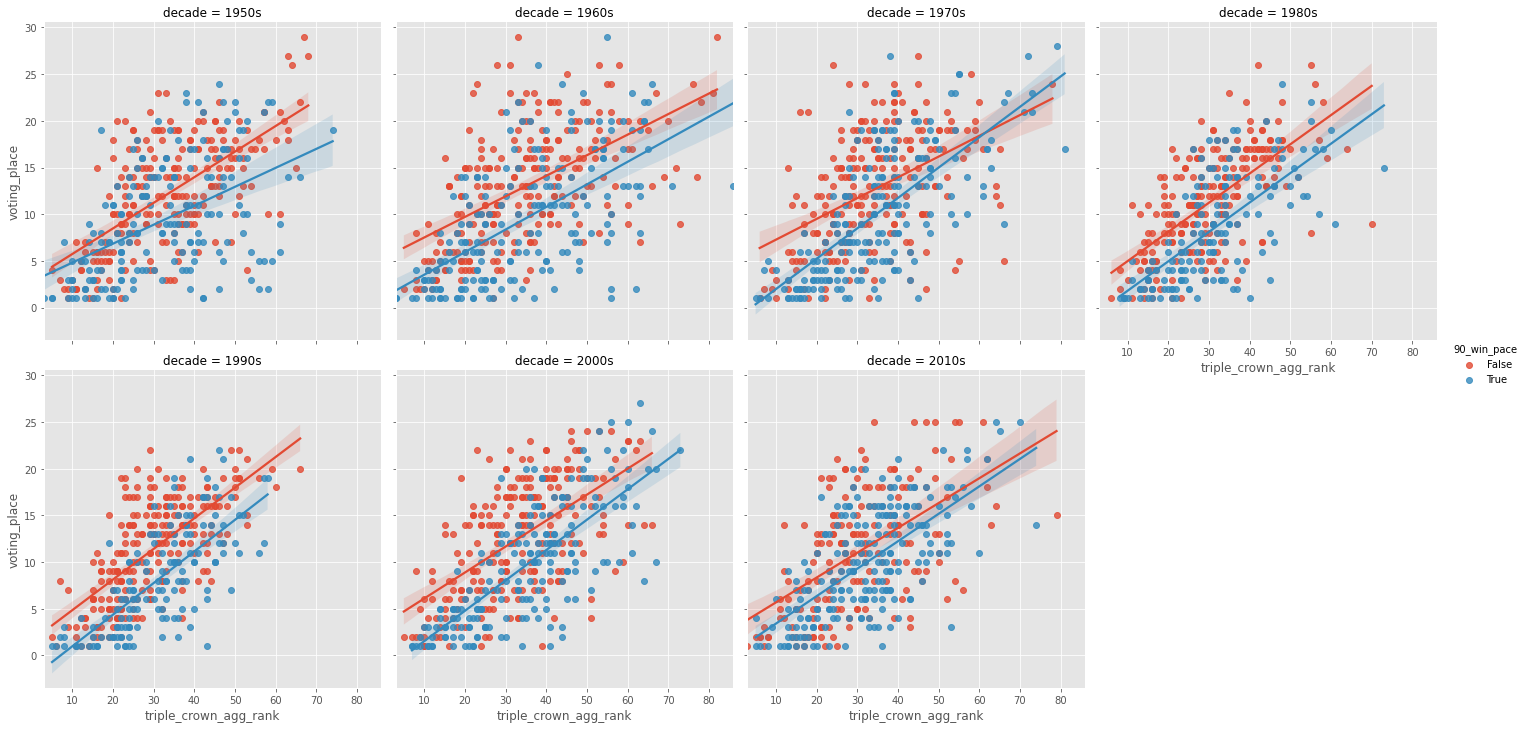

In [43]:
sns.lmplot(x="triple_crown_agg_rank", y="voting_place",data=df.sort_values('decade',ascending=True),col="decade",hue='90_win_pace',col_wrap=4)


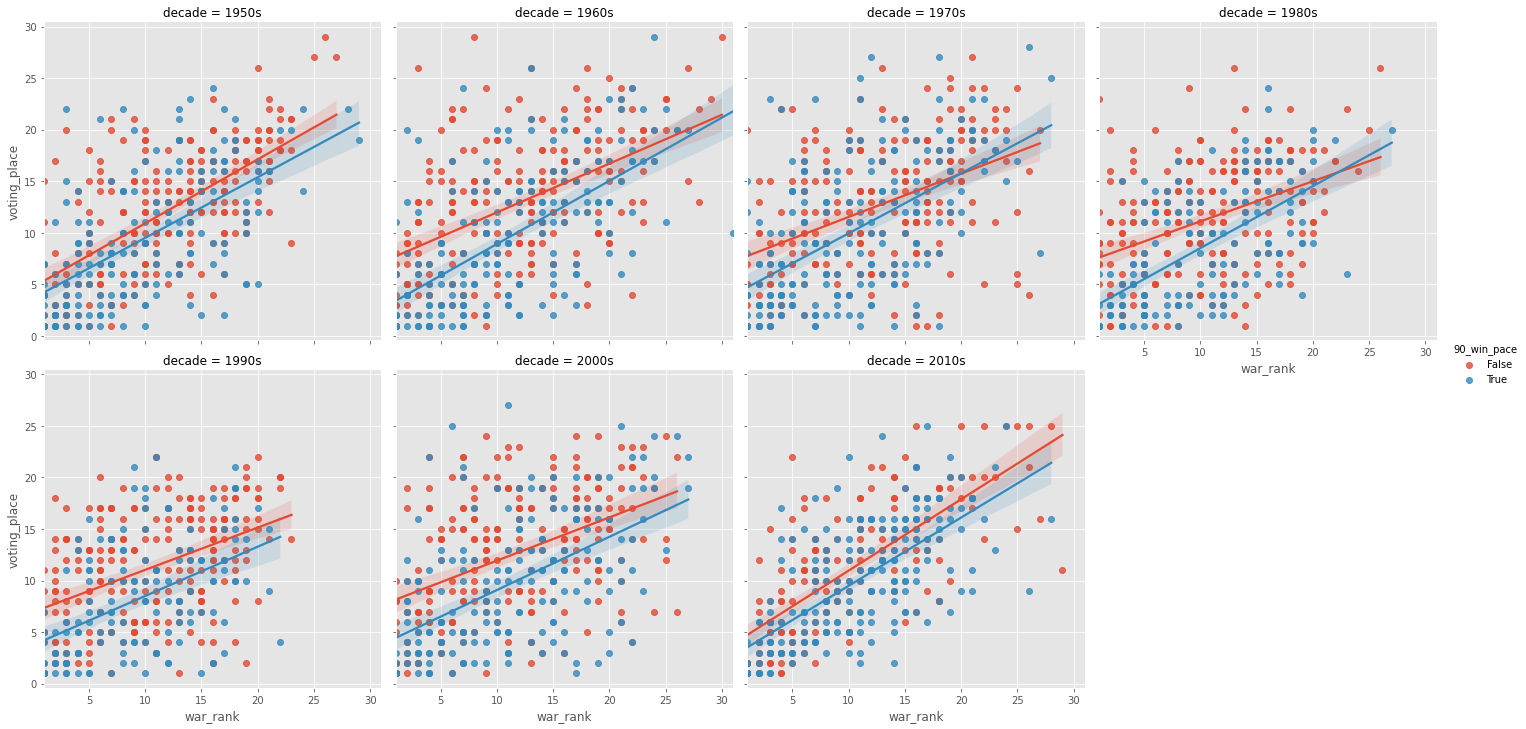

In [44]:
#sns.lmplot(x="war_rank", y="voting_place",data=df.loc[df['playoffs']=='No'].sort_values('decade',ascending=True),col="decade",col_wrap=3)
sns.lmplot(x="war_rank", y="voting_place",data=df.sort_values('decade',ascending=True),col="decade",hue='90_win_pace',col_wrap=4)


In [45]:
# for i in df.columns:
#     if 'triple' in i:
#         print(i)

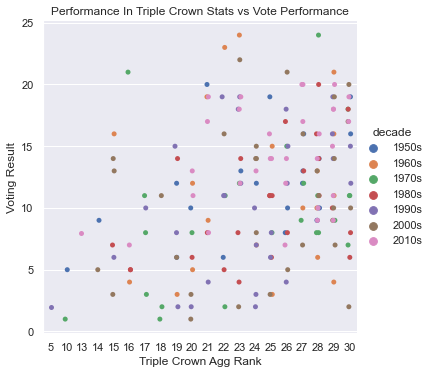

In [178]:
sns.catplot(x="triple_crown_agg_rank", y="voting_place",data=df.loc[df.war_rank>15].loc[df.triple_crown_agg_rank<31].sort_values('decade',ascending=True),jitter=True,hue='decade')
format_graph('Triple Crown Agg Rank','Voting Result','Performance In Triple Crown Stats vs Vote Performance')


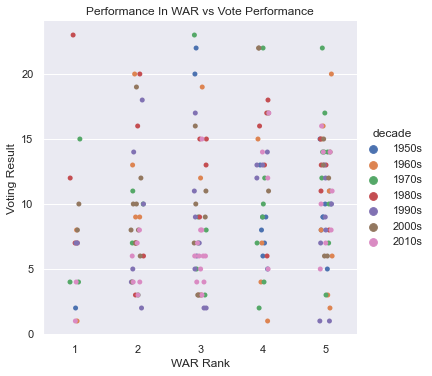

In [180]:
sns.catplot(x="war_rank", y="voting_place",data=df.loc[df.war_rank<6].loc[df.home_runs_rank>5].loc[df.rbi_rank>5].loc[df.average_rank>5].sort_values('decade',ascending=True),jitter=True,hue='decade')
format_graph('WAR Rank','Voting Result','Performance In WAR vs Vote Performance')

MVP Winners and how close they were to leading league and war and the war difference YoY by league

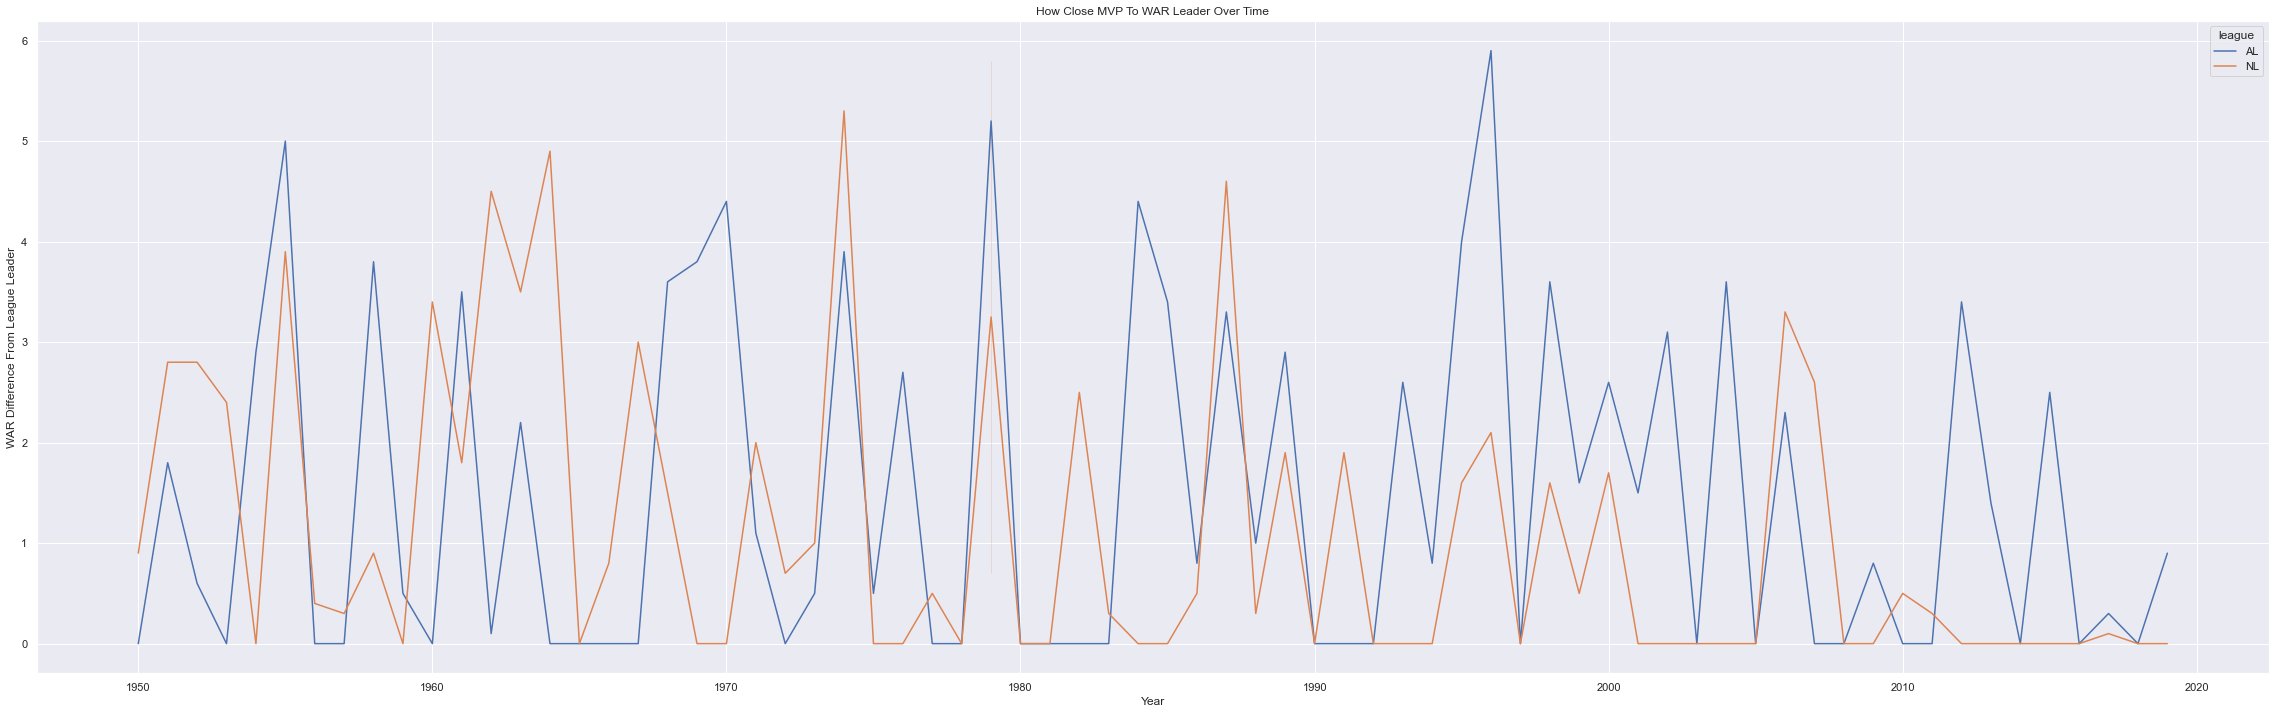

In [183]:
plt.figure(figsize=(40,12))
sns.lineplot(x='year', y='war_difference', data=df.loc[df.winner==True],hue='league')

format_graph('Year','WAR Difference From League Leader','How Close MVP To WAR Leader Over Time')

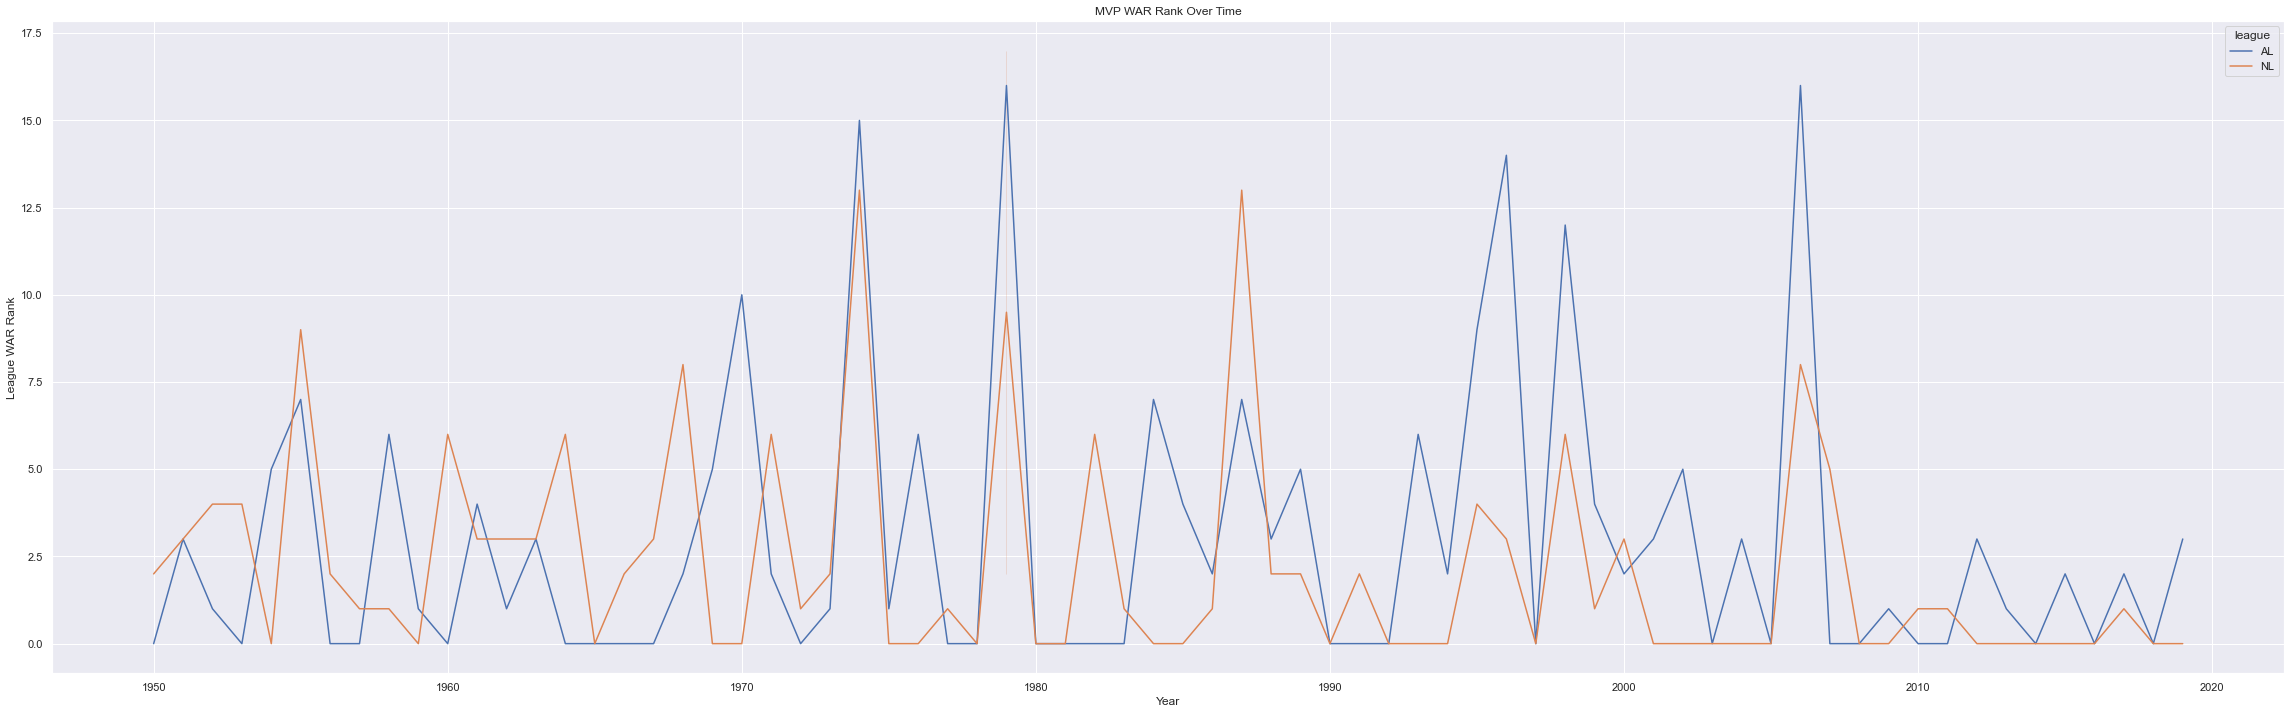

In [184]:
plt.figure(figsize=(40,12))
sns.lineplot(x='year', y='expected_vote_place_difference', data=df.loc[df.winner==True],hue='league')
format_graph('Year','League WAR Rank','MVP WAR Rank Over Time')

Top and Bottom 10 players in how they have performed in MVP voting vs WAR rank

In [140]:
# plotdata = pd.DataFrame({
#     "pies_2018":[40, 12, 10, 26, 36],
#     "pies_2019":[19, 8, 30, 21, 38],
#     "pies_2020":[10, 10, 42, 17, 37]
#     }, 
#     index=["Dad", "Mam", "Bro", "Sis", "Me"]
# )

In [139]:
# plotdata.plot(kind='bar', stacked=True)

In [137]:
# test = grouped.pivot(index='master_team', columns=['decade'], values=['expected_vote_place_difference'])
# test.fillna(0.0)
# test.plot(kind='bar', stacked=True)

In [157]:
# sns.set()
# plt.figure(figsize=(100,100))
# grouped.T.plot(kind='bar', stacked=True,figsize=(20,10))

In [158]:
# plt.figure(figsize=(40,10))
# grouped = df[['master_team','decade','expected_vote_place_difference']].groupby(['master_team','decade']).sum().reset_index().pivot(index='decade', columns=['master_team'], values=['expected_vote_place_difference']).fillna(0.0)
# grouped.plot(kind='bar', stacked=True)

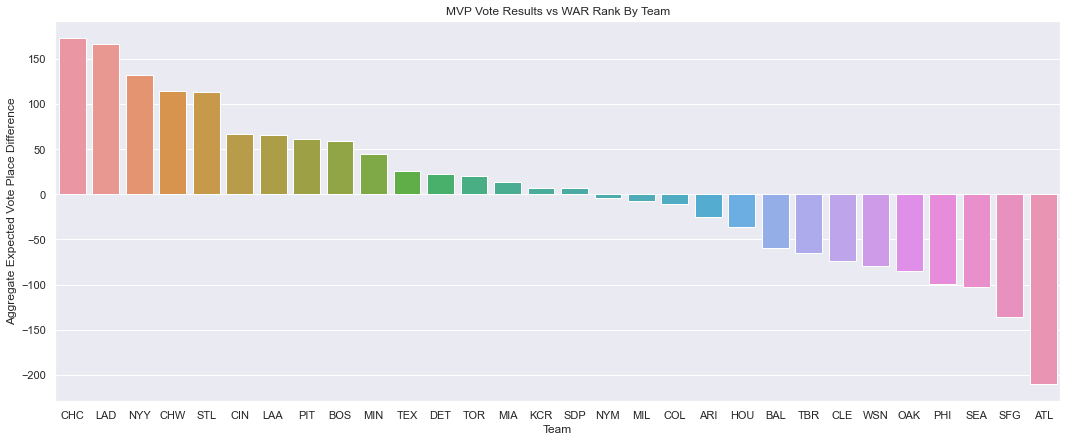

In [185]:
plt.figure(figsize=(18,7))
sns.barplot(x='master_team', y='expected_vote_place_difference', data=df.groupby(['master_team']).sum().reset_index().sort_values('expected_vote_place_difference',ascending=False))

format_graph('Team','Aggregate Expected Vote Place Difference','MVP Vote Results vs WAR Rank By Team')


Top and Bottom 10 players in how they have performed in MVP voting vs WAR rank

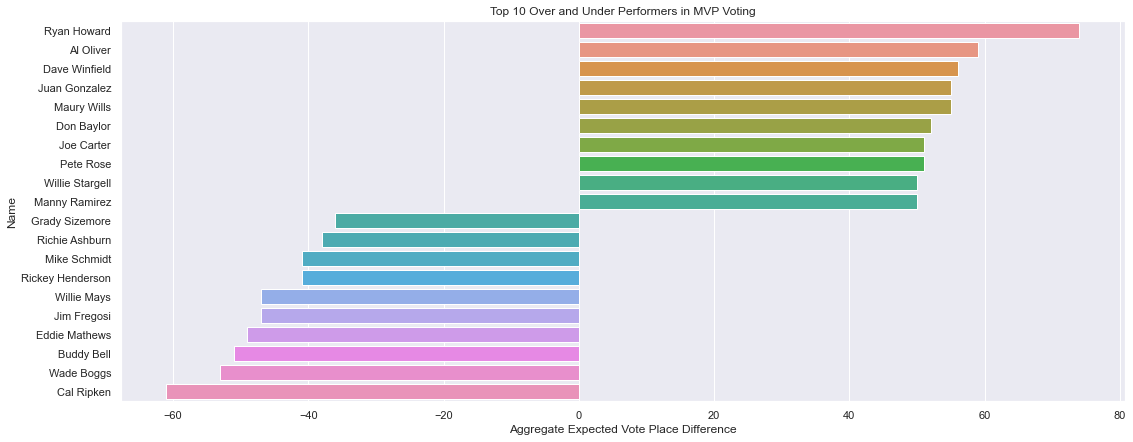

In [186]:
plt.figure(figsize=(18,7))
grouped_df = df.groupby(['name']).sum().reset_index().sort_values('expected_vote_place_difference',ascending=False)
sns.barplot(x='expected_vote_place_difference', y='name', data=pd.concat([grouped_df[:10],grouped_df[-10:]]),orient='h')

format_graph('Aggregate Expected Vote Place Difference','Name','Top 10 Over and Under Performers in MVP Voting')



In [89]:
# plt.figure(figsize=(18,7))
# grouped_df = df.groupby(['name']).sum().reset_index().sort_values('expected_vote_place_difference',ascending=False)
# sns.barplot(x='name', y='expected_vote_place_difference', data=grouped_df[-10:])

How extreme performance in certain categories may lead to automatic high voting finish

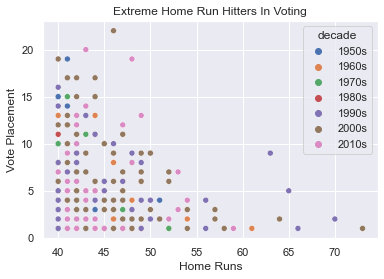

In [187]:
#plt.figure(figsize=(15,4))
sns.scatterplot(x="home_runs", y="voting_place",data=df.loc[df.home_runs>=40],x_jitter=True,hue='decade')
format_graph('Home Runs','Vote Placement','Extreme Home Run Hitters In Voting')

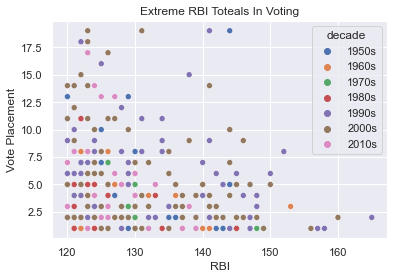

In [188]:
sns.scatterplot(x="rbi", y="voting_place",data=df.loc[df.rbi>=120],x_jitter=True,hue='decade')
format_graph('RBI','Vote Placement','Extreme RBI Toteals In Voting')

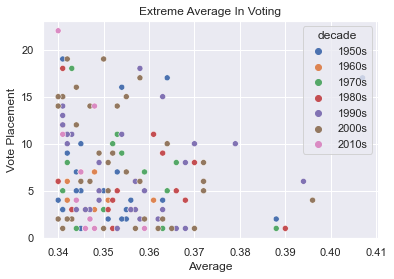

In [189]:
sns.scatterplot(x="average", y="voting_place",data=df.loc[df.average>=.340],x_jitter=True,hue='decade')
format_graph('Average','Vote Placement','Extreme Average In Voting')

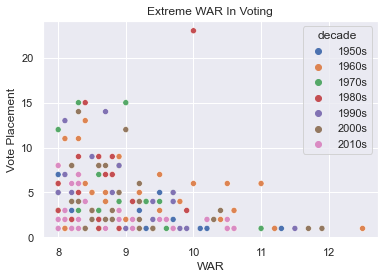

In [190]:
sns.scatterplot(x="war", y="voting_place",data=df.loc[df.war>=8],x_jitter=True,hue='decade')
format_graph('WAR','Vote Placement','Extreme WAR In Voting')